# Classification

In [20]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Image loading, binarization, inversion and display
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin_otsu(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    plt.figure()
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
    plt.show()
    
# Image morphological operations
def dilate(image, kernel, iterations = 1):
    return cv2.dilate(image, kernel, iterations)
def erode(image, kernel, iterations = 1):
    return cv2.erode(image, kernel, iterations)
def open_image(image, kernel = None):
    if kernel is None:
        kernel = np.ones((1, 100))
    return dilate(erode(image, kernel), kernel)

# Horizontal projection
def horizontal_projection(image):
    hor_proj = []
    for i in range(len(image)):
        row_sum = 0
        for j in range(len(image[i])):
            row_sum += image[i][j] == 255
        hor_proj.append([255] * row_sum + [0] * (len(image[0]) - row_sum))

    return hor_proj

# Image crop
def crop_image(image, crop_start = None, crop_width = None):
    if crop_width is None:
        crop_width = len(image[0]) // 10
        
    if crop_start is None:
        end = 0
        for row in image:
            s = sum(row) / 255
            if s > end:
                end = s

        crop_start = end - crop_width
        
    cutoff = image[:]
    
    for i in range(len(cutoff)):
        cutoff[i] = cutoff[i][crop_start : crop_start + crop_width] 

    cutoff = np.array(cutoff, dtype = np.uint8)
    return cutoff

# Find Y coordinates of white pixels
def find_y(image):
    y = []
    for i in range(len(image)):
        for j in range(len(image[i])):
            if (image[i][j] == 255) and (i not in y):
                y.append(i)
    return sorted(y)

# Intersect two lists
def intersect_lists(first, second):
    ret_val = []
    for val in first:
        if val in second:
            ret_val += [val]
    return ret_val

# Group points and get distances
def label_y(y_list):
    labels = [[]]
    line_distances = []
    prev_y = None
    for y in y_list:
        if prev_y is not None:
            if y - prev_y > 1:
                labels.append([])
                line_distances += [y - prev_y]
        labels[-1] += [y]
        prev_y = y
    return labels, line_distances

# Find lines
def find_lines(image):
    first = find_y(crop_image(horizontal_projection(image)))
    second = find_y(open_image(image))
    
    
    lines, distances = label_y(intersect_lists(first, second))
    staff_spacings = [distances[i] for i in range(len(distances)) if (i+1) % 5 != 0 ]
    staff_spacing = sum(staff_spacings) * 1./len(staff_spacings)
    return lines, distances, staff_spacing

# Remove lines
def remove_lines(org_image, tolerance = 0, lines = None, topBotPixelRemoval = True, widthBasedRemoval = True):
    image = org_image.copy()
    
    if lines == None:
        lines, distances, staff_spacing = find_lines(org_image)
    
    if topBotPixelRemoval:
        for line in lines:
            top = line[0]
            bot = line[-1]
            for j in range(len(image[top])):
                remove = True
                is_line = False
                for row in image[top:bot+1]:
                    if row[j] == 255:
                        is_line = True
                        break
                if not is_line:
                    continue
                # check 2 pixels above and below
                diff = 2
                for row in image[top - diff : top]:
                    if row[j] == 255:
                        remove = False
                        break
                if remove:
                    for row in image[bot + 1: bot + diff + 1]:
                        if row[j] == 255:
                            remove = False
                            break
                if remove:
                    for row in image[top:bot+1]:
                        row[j] = 0
    
    if widthBasedRemoval:
        avg_thickness = lines[:]
        for i, line in enumerate(avg_thickness):
            avg_thickness[i] = len(line)
        avg_thickness = sum(avg_thickness) * 1./len(avg_thickness)

        for j in range(len(image[0])):
            white = False
            for i in range(len(image)):
                if image[i][j] == 255:
                    if not white:
                        start = i
                    white = True
                else:
                    if white:
                        thickness = i - start
                        if thickness <= (avg_thickness + tolerance):
                            for row in image[start : i]:
                                row[j] = 0
                    white = False
    return image

def add_region(image, row, col, regions):
    append = True
    coords = [(row, col)]
    idx = 0
    while (idx < len(coords)):
        row, col = coords[idx]
        for dr in range(-1,2):
            for dc in range(-1,2):
                r = row + dr
                c = col + dc
                if r >= 0 and c >= 0 and r < len(image) and c < len(image[r]):
                    if image[r][c] == 255 and ((r,c) not in coords):
                        skip = False
                        for region in regions:
                            if (r,c) in region:
                                skip = True
                                append = False
                                for coord in coords:
                                    region.append((r,c))
                        if not skip:
                            coords += [(r,c)]
        idx += 1
    if append:
        regions.append(coords)

def find_vertical_lines(image):
    # Find lines, distances
    lines, distances, staff_spacing = find_lines(image)

    # Find vertical objects
    img_open = open_image(remove_lines(image), np.ones((1.5 * staff_spacing, 1)))
    return img_open

def find_regions(org_image, ref_image = None):
    if ref_image is None:
        ref_image = org_image
    # Label regions of interest
    regions = []
    for row in range(len(ref_image)):
        for col in range(len(ref_image[row])):
            if ref_image[row][col] == 255:
                isFound = False
                for region in regions:
                    if (row,col) in region:
                        isFound = True
                        break
                if not isFound:
                    add_region(org_image, row, col, regions)
    
    img_regions = org_image.copy()
    for row in range(len(img_regions)):
        for col in range(len(img_regions[row])):
            img_regions[row][col] = 0

    for region in regions:
        for row, col in region:
            img_regions[row, col] = 255
            
    return img_regions, regions

def find_vertical_objects(image, image_vert_lines):
    return find_regions(image, image_vert_lines)

def split_image(image, regions):
    split_images = []
    for region in regions:
        minr = min([r for r,c in region])
        maxr = max([r for r,c in region])
        minc = min([c for r,c in region])
        maxc = max([c for r,c in region])
        sub_image = []
        for row in range(minr,maxr+1):
            sub_image.append([])
            for col in range(minc,maxc+1):
                sub_image[-1] += [image[row][col]]
        sub_image = np.array(sub_image)
        sub_image = np.uint8(sub_image)
        split_images.append(sub_image)
    return split_images

## Clefs
In this section we will try to recognize and classify clefs, and they will be the first vertical objects we'll have to recognize, so we can later remove them.

### G-Clef

First, we have to find all vertical objects.

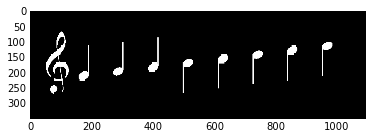

In [15]:
org_image = load_image("test_images/staff-with-notes.jpg")
img_gray = image_gray(org_image)
img_otsu = image_bin_otsu(img_gray)
inv_img = invert(img_otsu)
img_wo_lines = remove_lines(inv_img)
display_image(img_wo_lines)

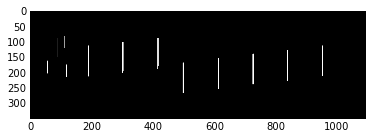

In [16]:
img_vert_lines = find_vertical_lines(inv_img)
display_image(img_vert_lines)

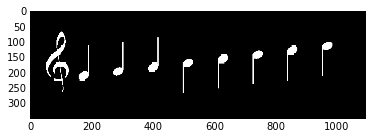

Number of recognized objects: 9


In [21]:
img_vert_objects, regions = find_vertical_objects(img_wo_lines, img_vert_lines)
display_image(img_vert_objects)
print("Number of recognized objects: %s" % len(regions))

Now, we'll split the objects into separate images.

First found object:


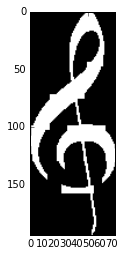

In [22]:
objects = split_image(img_vert_objects, regions)
print("First found object:")
display_image(objects[0])

Now we'll search for G-clef templates.

In [23]:
from os import listdir
from os.path import isdir
g_clef_templates = []

vertFile = "clefs/g_clef"
split = vertFile.split('/')
for listedFile in listdir("templates"):
    if listedFile == split[0]:
        for innerFile in listdir("templates/%s" % listedFile):
            if len(split) == 1 or innerFile.startswith(split[1]):
                g_clef_templates += ["templates/%s/%s" % (listedFile, innerFile)]

print(g_clef_templates)

['templates/clefs/g_clef_01.jpg', 'templates/clefs/g_clef_02.jpg', 'templates/clefs/g_clef_03.jpg', 'templates/clefs/g_clef_04.jpg']


Next, we try to resize the templates so their size is equal to vertical objects bounding box.

Original template


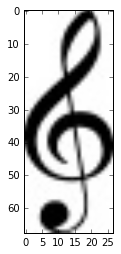

Resized template


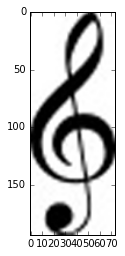

Processed template


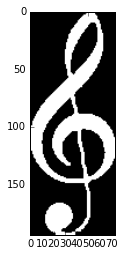

In [24]:
def resize_image(tmp_img, new_width, new_height):
    return cv2.resize(tmp_img, (int(round(new_width)), int(round(new_height))), interpolation = cv2.INTER_CUBIC)

g_clef = objects[0]
g_clef_height, g_clef_width = g_clef.shape[:2]

for template in g_clef_templates:
    print("Original template")
    tmp_img = load_image(template)
    display_image(tmp_img)
    height, width = tmp_img.shape[:2]
    tmp_img = resize_image(tmp_img, g_clef_width, g_clef_height)
    print("Resized template")
    display_image(tmp_img)
    tmp_img = image_gray(tmp_img)
    tmp_img = image_bin_otsu(tmp_img)
    tmp_img = invert(tmp_img)
    print("Processed template")
    display_image(tmp_img)
    break

And finally, we compare the segmented object with templates. This is done by comparing each corresponding pixels.

In [25]:
g_clef = objects[0]
g_clef_height, g_clef_width = g_clef.shape[:2]
for template in g_clef_templates:
    print("Template matching: %s" % template)
    template_name = template
    # Template Image Processing
    template = load_image(template)
    template = resize_image(template,g_clef_width,g_clef_height)
    template = image_gray(template)
    template = image_bin_otsu(template)
    template = invert(template)
    match = 0
    for row in range(len(template)):
        for col in range(len(template[row])):
            match += 1 if g_clef[row][col] == template[row][col] else 0
                
                
    # Normalize
    match *= 1./(g_clef_width * g_clef_height)
    print("match: %d%%" % (match*100))

Template matching: templates/clefs/g_clef_01.jpg
match: 76%
Template matching: templates/clefs/g_clef_02.jpg
match: 84%
Template matching: templates/clefs/g_clef_03.jpg
match: 81%
Template matching: templates/clefs/g_clef_04.jpg
match: 73%


Since theoretically there could more than one clef in a staff, we should template match all objects.

In [34]:
def match_clef(obj, clef_templates):
    obj_height, obj_width = obj.shape[:2]
    best_match = (None, 0)
    for template in clef_templates:
        template_name = template
        # Template Image Processing
        template = load_image(template)
        template = resize_image(template,obj_width,obj_height)
        template = image_gray(template)
        template = image_bin_otsu(template)
        template = invert(template)
        match = 0
        for row in range(len(template)):
            for col in range(len(template[row])):
                match += 1 if obj[row][col] == template[row][col] else 0


        # Normalize
        match *= 1./(obj_width * obj_height)
        if match > best_match[1]:
            best_match = (template_name, match)
    print("Best match: %d%%" % (best_match[1]*100))
    print("Template name: %s" % best_match[0])
    return best_match
        
for obj in objects:
    match_clef(obj, g_clef_templates)

Best match: 51%
Template name: templates/clefs/g_clef_04.jpg
Best match: 63%
Template name: templates/clefs/g_clef_04.jpg
Best match: 63%
Template name: templates/clefs/g_clef_04.jpg
Best match: 56%
Template name: templates/clefs/g_clef_04.jpg
Best match: 57%
Template name: templates/clefs/g_clef_04.jpg
Best match: 55%
Template name: templates/clefs/g_clef_01.jpg
Best match: 60%
Template name: templates/clefs/g_clef_04.jpg
Best match: 57%
Template name: templates/clefs/g_clef_02.jpg
Best match: 62%
Template name: templates/clefs/g_clef_02.jpg
Best match: 60%
Template name: templates/clefs/g_clef_04.jpg


As we can see, the first object is most probably (and it is) a G-clef.

However, when we put other clefs into possible templates...

In [27]:
clef_templates = []

vertFile = "clefs"
split = vertFile.split('/')
for listedFile in listdir("templates"):
    if listedFile == split[0]:
        for innerFile in listdir("templates/%s" % listedFile):
            if len(split) == 1 or innerFile.startswith(split[1]):
                clef_templates += ["templates/%s/%s" % (listedFile, innerFile)]

print(clef_templates)

['templates/clefs/c_clef_01.jpg', 'templates/clefs/c_clef_02.jpg', 'templates/clefs/c_clef_03.jpg', 'templates/clefs/f_clef_01.jpg', 'templates/clefs/f_clef_02.jpg', 'templates/clefs/g_clef_01.jpg', 'templates/clefs/g_clef_02.jpg', 'templates/clefs/g_clef_03.jpg', 'templates/clefs/g_clef_04.jpg']


In [28]:
for obj in objects:
    match_clef(obj, clef_templates)

Best match: 84%
Template name: templates/clefs/g_clef_02.jpg
Best match: 59%
Template name: templates/clefs/g_clef_04.jpg
Best match: 60%
Template name: templates/clefs/c_clef_03.jpg
Best match: 62%
Template name: templates/clefs/f_clef_01.jpg
Best match: 59%
Template name: templates/clefs/g_clef_04.jpg
Best match: 63%
Template name: templates/clefs/f_clef_01.jpg
Best match: 62%
Template name: templates/clefs/f_clef_01.jpg
Best match: 63%
Template name: templates/clefs/f_clef_01.jpg
Best match: 62%
Template name: templates/clefs/f_clef_01.jpg


...we're still good.

### C-Clef
Let's try to recognize C-Clef.

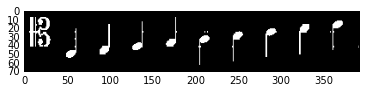

In [46]:
org_image = load_image("test_images/c_clef_notes.jpg")
img_gray = image_gray(org_image)
img_otsu = image_bin_otsu(img_gray)
inv_img = invert(img_otsu)
img_wo_lines = remove_lines(inv_img)
display_image(img_wo_lines)

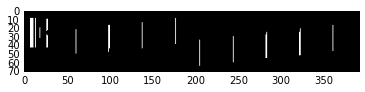

In [47]:
img_vert_lines = find_vertical_lines(inv_img)
display_image(img_vert_lines)

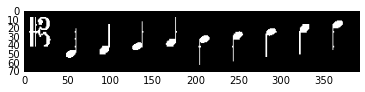

Number of recognized objects: 10


In [48]:
img_vert_objects, regions = find_vertical_objects(img_wo_lines, img_vert_lines)
display_image(img_vert_objects)
print("Number of recognized objects: %s" % len(regions))

Best match: 80%
Template name: templates/clefs/c_clef_01.jpg
Best match: 63%
Template name: templates/clefs/g_clef_04.jpg
Best match: 63%
Template name: templates/clefs/g_clef_04.jpg
Best match: 57%
Template name: templates/clefs/f_clef_02.jpg
Best match: 64%
Template name: templates/clefs/f_clef_01.jpg
Best match: 61%
Template name: templates/clefs/f_clef_01.jpg
Best match: 60%
Template name: templates/clefs/g_clef_04.jpg
Best match: 67%
Template name: templates/clefs/c_clef_01.jpg
Best match: 66%
Template name: templates/clefs/f_clef_01.jpg
Best match: 65%
Template name: templates/clefs/f_clef_02.jpg
Segmented image:


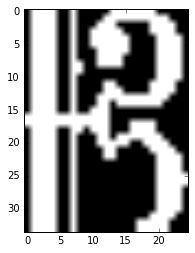

Best template:


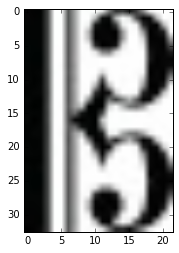

In [49]:
objects = split_image(img_vert_objects, regions)
        
best_obj = (None, (None, 0))
for obj in objects:
    match = match_clef(obj, clef_templates)
    if match[1] > best_obj[1][1]:
        best_obj = (obj, match)
print("Segmented image:")
display_image(best_obj[0])
print("Best template:")
display_image(load_image(best_obj[1][0]))

### F-Clef
And finally, the F-clef.

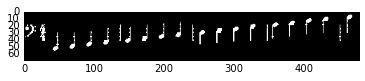

In [38]:
org_image = load_image("test_images/f_clef_notes.jpg")
img_gray = image_gray(org_image)
img_otsu = image_bin_otsu(img_gray)
inv_img = invert(img_otsu)
img_wo_lines = remove_lines(inv_img)
display_image(img_wo_lines)

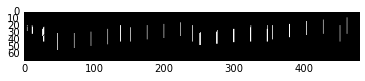

In [39]:
img_vert_lines = find_vertical_lines(inv_img)
display_image(img_vert_lines)

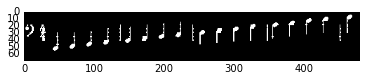

Number of recognized objects: 24


In [40]:
img_vert_objects, regions = find_vertical_objects(img_wo_lines, img_vert_lines)
display_image(img_vert_objects)
print("Number of recognized objects: %s" % len(regions))

Best match: 60%
Template name: templates/clefs/f_clef_01.jpg
Best match: 63%
Template name: templates/clefs/f_clef_01.jpg
Best match: 63%
Template name: templates/clefs/f_clef_01.jpg
Best match: 59%
Template name: templates/clefs/f_clef_02.jpg
Best match: 62%
Template name: templates/clefs/c_clef_03.jpg
Best match: 67%
Template name: templates/clefs/f_clef_01.jpg
Best match: 62%
Template name: templates/clefs/g_clef_03.jpg
Best match: 71%
Template name: templates/clefs/f_clef_02.jpg
Best match: 65%
Template name: templates/clefs/c_clef_02.jpg
Best match: 57%
Template name: templates/clefs/c_clef_03.jpg
Best match: 52%
Template name: templates/clefs/g_clef_04.jpg
Best match: 60%
Template name: templates/clefs/f_clef_01.jpg
Best match: 69%
Template name: templates/clefs/c_clef_03.jpg
Best match: 67%
Template name: templates/clefs/f_clef_01.jpg
Best match: 60%
Template name: templates/clefs/g_clef_03.jpg
Best match: 50%
Template name: templates/clefs/f_clef_01.jpg
Best match: 61%
Template

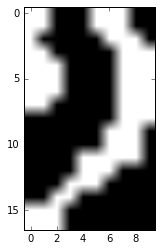

Best template:


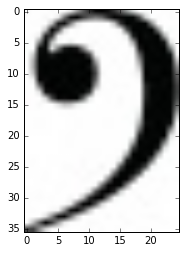

In [44]:
objects = split_image(img_vert_objects, regions)
        
best_obj = (None, (None, 0))
for obj in objects:
    match = match_clef(obj, clef_templates)
    if match[1] > best_obj[1][1]:
        best_obj = (obj, match)
print("Segmented image:")
display_image(best_obj[0])
print("Best template:")
display_image(load_image(best_obj[1][0]))

This one was a little harder to recognize, because it's not entirely connected and it's not as vertical as other vertical objects. We'll try to recognize it again when we move on to non-vertical objects.